# **Importing and Installing Libraries**

In [ ]:
!pip install astroquery

In [ ]:
from astroquery.gaia import Gaia
import numpy as np
import pandas as pd



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from termcolor import colored
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score

# **Importing Data and storing in a Dataframe and adding calculated columns**

In [ ]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
query = "SELECT * FROM gaiadr3.gaia_source WHERE parallax IS NOT NULL AND pmra IS NOT NULL AND pmdec IS NOT NULL AND phot_bp_mean_mag IS NOT NULL"
job = Gaia.launch_job(query)
astropy_table = job.get_results()
df = astropy_table.to_pandas()
column=['source_id', 'ref_epoch', 'ra', 'dec', 'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',  'bp_rp', 'bp_g', 'g_rp']
df = df[column]
df.isna().sum()

source_id           0
ref_epoch           0
ra                  0
dec                 0
parallax            0
pmra                0
pmdec               0
phot_g_mean_mag     0
phot_bp_mean_mag    0
phot_rp_mean_mag    0
bp_rp               0
bp_g                0
g_rp                0
dtype: int64

In [ ]:
df.shape

(2000, 13)

In [ ]:
df=df.dropna()

In [ ]:
df.shape

(2000, 13)

In [ ]:
df['radial_velocity'] = (np.sqrt(df['pmra']**2 + df['pmdec']**2) * df['parallax'] / 206265) * np.tan(np.radians(90)) /(10**(0.2 * (df['phot_g_mean_mag'] - df['phot_rp_mean_mag'])))

In [ ]:
df['grvs_mag'] = df['phot_g_mean_mag'] - 0.31 * df['bp_rp']

In [ ]:
df['teff_gspphot'] = 10.0 ** (0.4 * (df['grvs_mag'] - df['phot_g_mean_mag']))

In [ ]:
df['logg_gspphot'] = 4.44 + 0.37 * (df['phot_bp_mean_mag'] - df['phot_rp_mean_mag']) - 0.0026 * df['teff_gspphot']

In [ ]:
df['mh_gspphot'] = -0.11 * (df['teff_gspphot'] - 5777) + 0.24 * (df['logg_gspphot'] - 4.44)

In [ ]:
df['teff'] = 5040 / (df['bp_rp'] - 0.33 * df['g_rp'] + 0.17)

In [ ]:
df['distance'] = 1 / df['parallax']
t= np.log10(df['distance'])
df['absolute_g_mean_mag'] = df['phot_g_mean_mag'] + 5 * t
df['luminosity'] = 10**((df['absolute_g_mean_mag'] - 4.83) / 2.5)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
df['mass'] = df['luminosity']**(3/4)
df['luminosity']= np.log10(df['luminosity'])

In [ ]:
df.shape

(2000, 23)

In [ ]:
df.isna().sum()

source_id                0
ref_epoch                0
ra                       0
dec                      0
parallax                 0
pmra                     0
pmdec                    0
phot_g_mean_mag          0
phot_bp_mean_mag         0
phot_rp_mean_mag         0
bp_rp                    0
bp_g                     0
g_rp                     0
radial_velocity          0
grvs_mag                 0
teff_gspphot             0
logg_gspphot             0
mh_gspphot               0
teff                     0
distance                 0
absolute_g_mean_mag    557
luminosity             557
mass                   557
dtype: int64

# **Understanding the Patterns in the data**

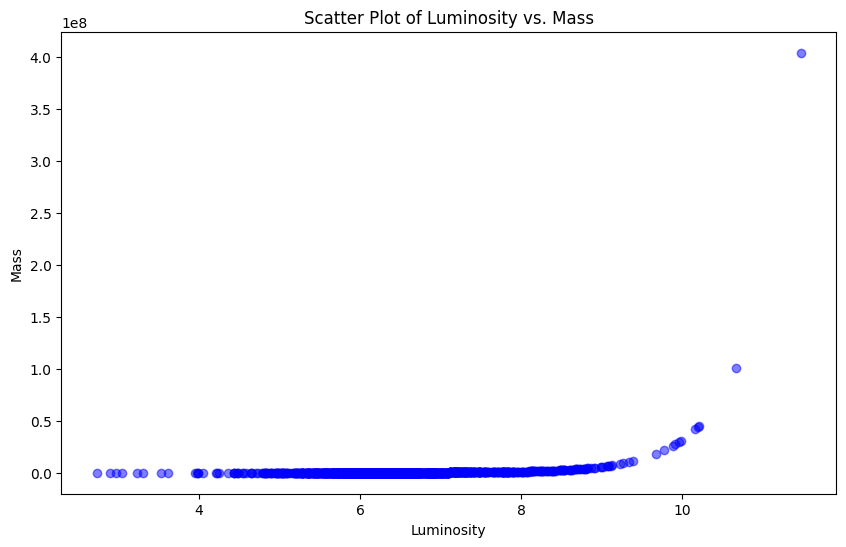

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['luminosity'], df['mass'], c='blue', alpha=0.5)
plt.xlabel('Luminosity')
plt.ylabel('Mass')
plt.title('Scatter Plot of Luminosity vs. Mass')
plt.show()

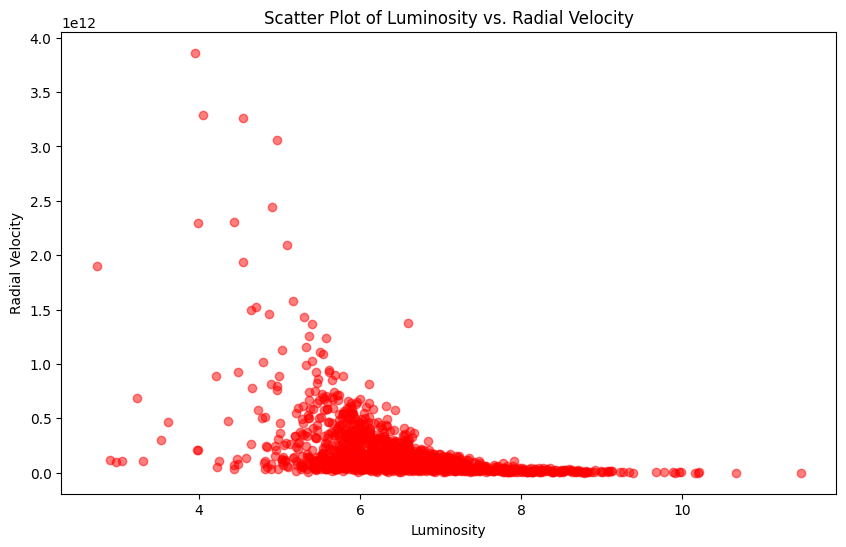

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['luminosity'], df['radial_velocity'], c='red', alpha=0.5)
plt.xlabel('Luminosity')
plt.ylabel('Radial Velocity')
plt.title('Scatter Plot of Luminosity vs. Radial Velocity')
plt.show()

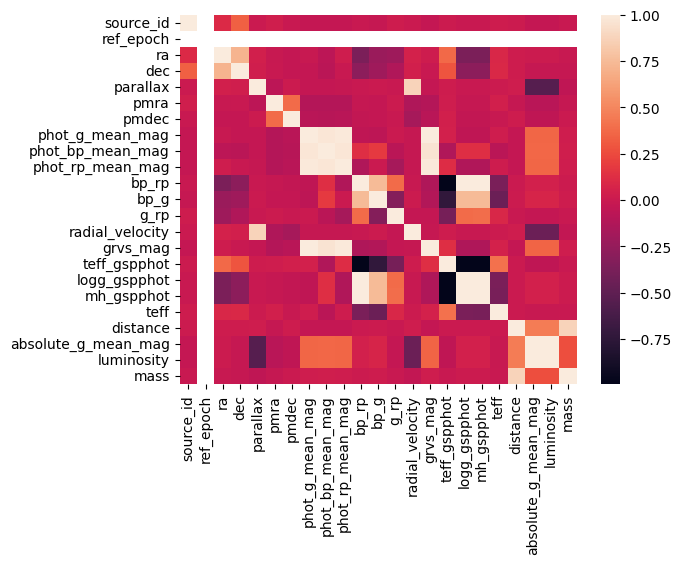

<Figure size 2000x5000 with 0 Axes>

In [ ]:
sns.heatmap(df.corr(), annot=False)
plt.figure(figsize=(20, 50))
plt.show()

In [ ]:
df=df.dropna()
df.shape

(1443, 23)

In [ ]:
df[features].describe().style.background_gradient(cmap="magma")

,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,bp_g,g_rp,radial_velocity,grvs_mag,teff_gspphot,logg_gspphot,mh_gspphot,teff,distance,absolute_g_mean_mag,luminosity,mass
count,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000
mean,287.912438,2.496237,0.591345,-2.130576,-4.747885,18.848339,19.688007,17.880669,1.807340,0.839669,0.967671,183576433250.083527,18.288063,0.599275,5.107158,635.564209,3196.233643,6.219570,21.044797,6.485919,831356.820896
std,0.546695,0.176562,0.710519,2.426073,2.996631,1.431931,1.449086,1.440740,0.316711,0.305258,0.218051,292887437643.101990,1.437615,0.052766,0.117320,0.033938,2152.895020,24.584841,2.383750,0.953500,11270400.958509
min,287.075005,2.206205,0.001535,-21.806964,-36.945325,11.367423,12.094643,10.537190,0.575949,-1.600107,-0.039759,465386996.258777,10.884613,0.325883,4.650895,635.427307,1387.213257,0.098863,11.650564,2.728225,111.216471
25%,287.567043,2.288749,0.212552,-3.504847,-6.412155,18.181572,18.958586,17.208085,1.614985,0.692533,0.835901,45337915319.991165,17.635874,0.568116,5.035905,635.543640,2779.843140,1.418159,19.608774,5.911510,27141.398055
50%,287.615661,2.590773,0.396352,-2.241245,-4.898062,19.195328,19.977688,18.182699,1.769938,0.839975,0.937094,99090760188.082581,18.655203,0.603292,5.093308,635.560425,3094.685059,2.523008,20.829442,6.399777,63071.437016
75%,288.463368,2.620600,0.705141,-0.943758,-3.114968,19.923568,20.745934,18.926629,1.980346,1.006709,1.061007,206696948014.796509,19.356212,0.630582,5.171251,635.583008,3394.618652,4.704743,22.194232,6.945693,161908.531146
max,288.783650,2.724463,10.115047,13.535490,7.362920,20.719210,22.526403,20.722822,3.926917,2.521663,2.421370,3861627940163.619629,20.461823,0.848364,5.892112,635.782654,80483.820312,651.634826,33.517575,11.475030,403898760.817723


# **Labelling The data**

In [ ]:
features = [ 'ra', 'dec', 'parallax', 'pmra', 'pmdec',
       'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp',
       'bp_g', 'g_rp', 'radial_velocity', 'grvs_mag', 'teff_gspphot',
       'logg_gspphot', 'mh_gspphot', 'teff', 'distance', 'absolute_g_mean_mag',
       'luminosity', 'mass']

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[features])
cluster_labels = kmeans.predict(df[features])
df['cluster_label'] = cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df['cluster_label'].shape

(1443,)

# **Splitting the data in Training and Testing sets**

In [ ]:

X=df[features]
y=df['cluster_label']


In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
X=X_resampled
y=y_resampled

In [ ]:
counts = {}
for category in y:
    if category in counts:
        counts[category] += 1
    else:
        counts[category] = 1

# Display the counts
for category, count in counts.items():
    print(f'{category}: {count}')

0: 1352
2: 1352
1: 1352
3: 1352


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
column_names = ["Name of Model", "Accuracy Score", "Precision", "Recall", "F1 Score"]
Metrics = pd.DataFrame(columns=column_names)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, auc
def confusion(Ytest, Ypredicted):
  conf_matrix = confusion_matrix(Ytest,Ypredicted)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, annot_kws={"size": 16})
  plt.title('Predicted Labels',y = 1.05, fontsize=20)
  plt.ylabel('True Labels', labelpad=25, fontsize=20)
  plt.show()
  print('-'*80)


# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter= 300)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [ ]:
predictions = clf.predict(X_test)

<ipython-input-34-8dbc54691f02>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Metrics = Metrics.append(log, ignore_index=True)


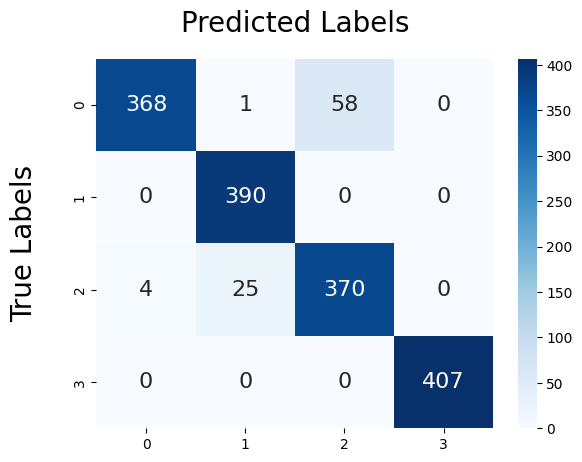

--------------------------------------------------------------------------------


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
model_name = 'Logistic Regression'
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')
log = pd.DataFrame({
    'Name of Model': [model_name],
    'Accuracy Score': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})
Metrics = Metrics.append(log, ignore_index=True)
confusion(y_test, predictions)


# **Support Vector Classifier**

In [ ]:
from sklearn.svm import SVC
svc= SVC()
svc.fit(X_train, y_train)

SVC()

In [ ]:
pred_svc = svc.predict(X_test)

<ipython-input-37-227c9e0c6922>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Metrics = Metrics.append(s, ignore_index=True)


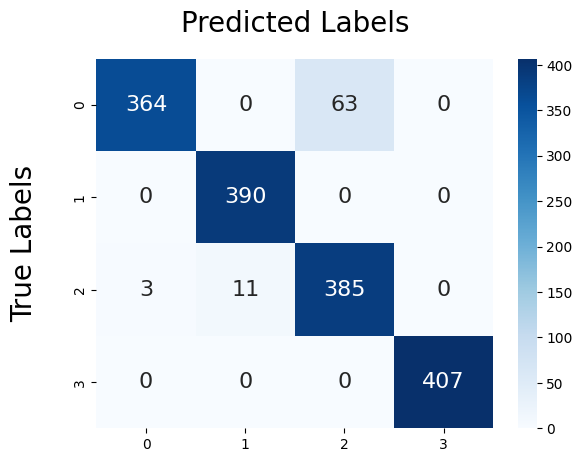

--------------------------------------------------------------------------------


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
model_name = 'SVC'
accuracy = accuracy_score(y_test, pred_svc)
precision = precision_score(y_test, pred_svc, average='weighted')
recall = recall_score(y_test, pred_svc, average='weighted')
f1 = f1_score(y_test, pred_svc, average='weighted')
s = pd.DataFrame({
    'Name of Model': [model_name],
    'Accuracy Score': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})
Metrics = Metrics.append(s, ignore_index=True)
confusion(y_test, pred_svc)

# **Stochastic Gradient Descent Classifier**

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.inspection import DecisionBoundaryDisplay
colors = "bry"
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
sgd.fit(X_train,y_train)




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=5)

In [ ]:
pred_sgd = sgd.predict(X_test)

<ipython-input-40-0a49db3463b4>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Metrics = Metrics.append(sg, ignore_index=True)


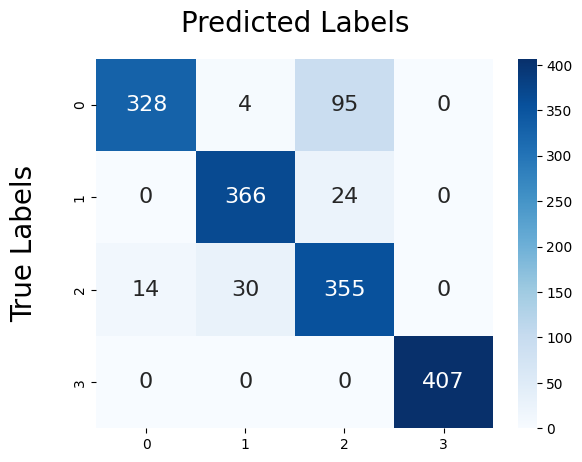

--------------------------------------------------------------------------------


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
model_name = 'Stochastic Gradient Classifier'
accuracy = accuracy_score(y_test, pred_sgd)
precision = precision_score(y_test, pred_sgd, average='weighted')
recall = recall_score(y_test, pred_sgd, average='weighted')
f1 = f1_score(y_test, pred_sgd, average='weighted')
sg = pd.DataFrame({
    'Name of Model': [model_name],
    'Accuracy Score': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})
Metrics = Metrics.append(sg, ignore_index=True)
confusion(y_test, pred_sgd)

# **Decision Tree**

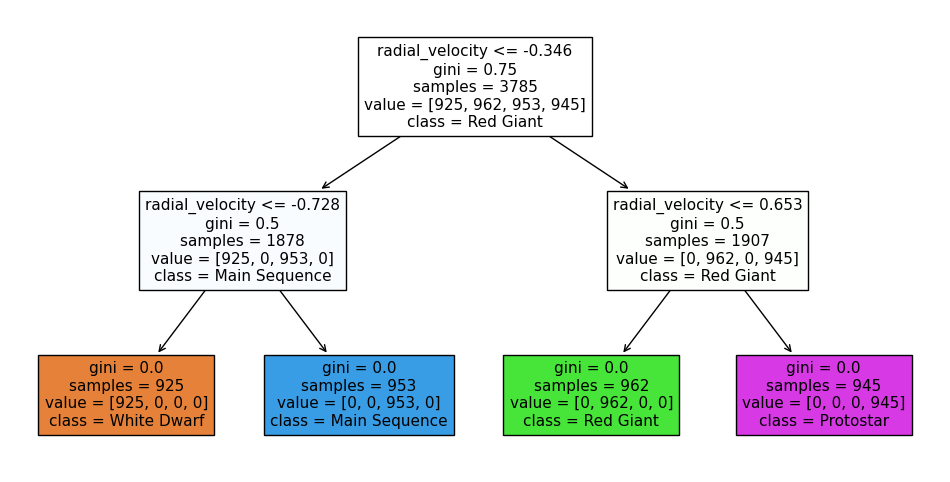

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dtc = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
dtc.fit(X_train, y_train)
class_names = ["White Dwarf", "Red Giant","Main Sequence","Protostar"]
plt.figure(figsize=(12, 6))
plot_tree(dtc, filled=True, feature_names=features, class_names=class_names)
plt.show()

In [ ]:
pred_dtc = dtc.predict(X_test)

<ipython-input-43-7a5b71b4c81f>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Metrics = Metrics.append(dt, ignore_index=True)


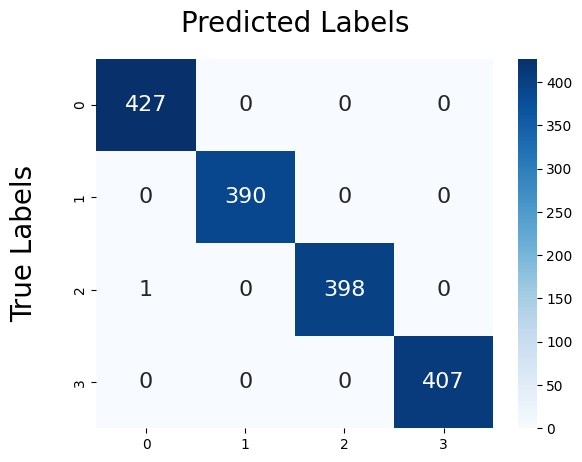

--------------------------------------------------------------------------------


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
model_name = 'Decision Tree'
accuracy = accuracy_score(y_test, pred_dtc)
precision = precision_score(y_test, pred_dtc, average='weighted')
recall = recall_score(y_test, pred_dtc, average='weighted')
f1 = f1_score(y_test, pred_dtc, average='weighted')
dt = pd.DataFrame({
    'Name of Model': [model_name],
    'Accuracy Score': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})
Metrics = Metrics.append(dt, ignore_index=True)
confusion(y_test, pred_dtc)

# **Random Forest Classifier**

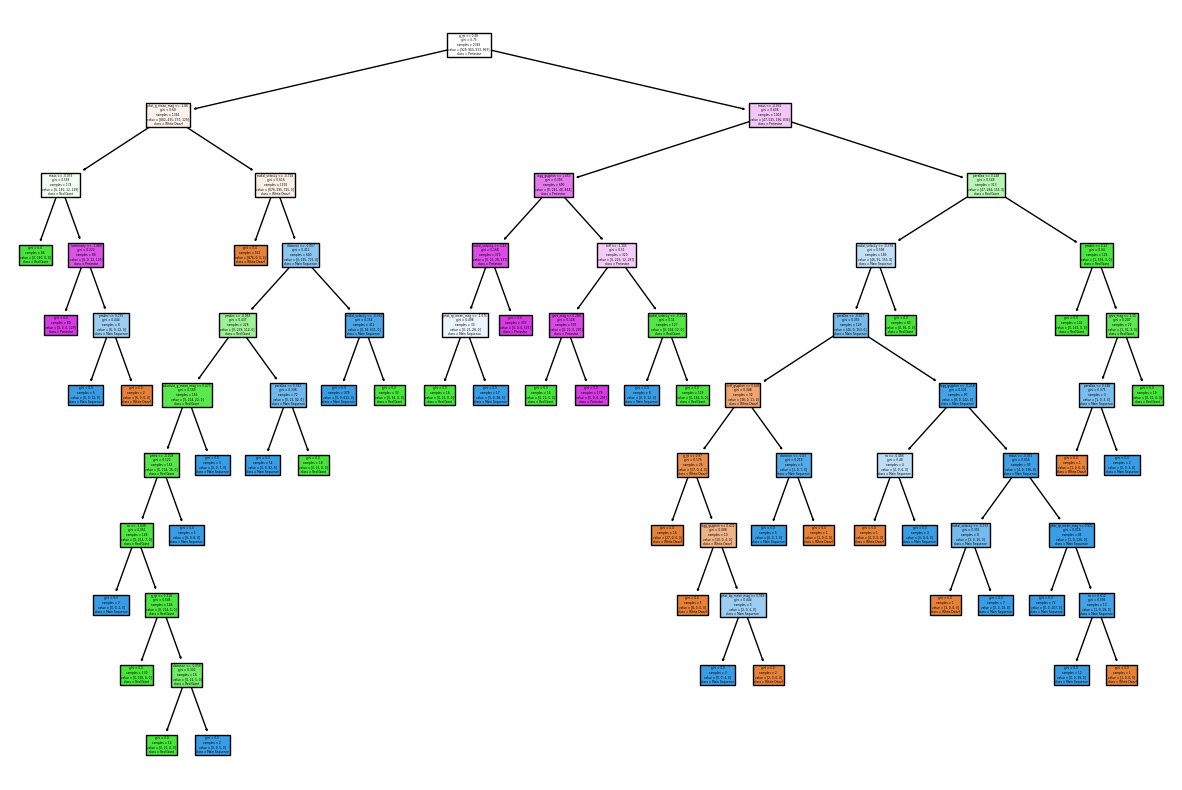

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)
plt.figure(figsize=(15, 10))
plot_tree(rfc.estimators_[0], feature_names=features, class_names= class_names, filled=True)
plt.show()

In [ ]:
pred_rfc = rfc.predict(X_test)

<ipython-input-46-22e4f74ec976>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Metrics = Metrics.append(rf, ignore_index=True)


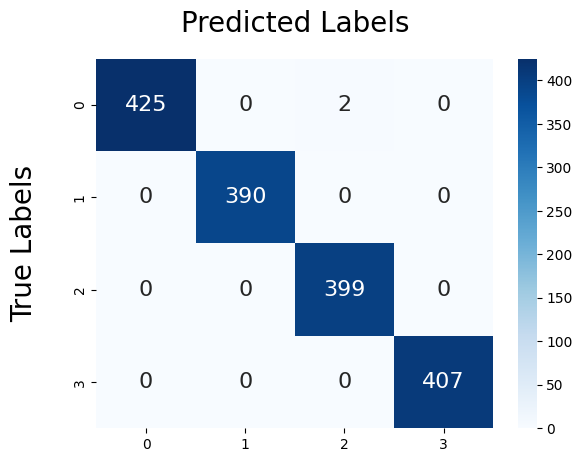

--------------------------------------------------------------------------------


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
model_name = 'Random Forest'
accuracy = accuracy_score(y_test, pred_rfc)
precision = precision_score(y_test, pred_rfc, average='weighted')
recall = recall_score(y_test, pred_rfc, average='weighted')
f1 = f1_score(y_test, pred_rfc, average='weighted')
rf = pd.DataFrame({
    'Name of Model': [model_name],
    'Accuracy Score': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})
Metrics = Metrics.append(rf, ignore_index=True)
confusion(y_test, pred_rfc)

# **Evaluation**

In [ ]:
styled_df = Metrics.style.background_gradient(cmap="magma")
styled_df

,Name of Model,Accuracy Score,Precision,Recall,F1 Score
0,Logistic Regression,0.945779,0.948838,0.945779,0.945642
1,SVC,0.952557,0.956686,0.952557,0.952440
2,Stochastic Gradient Classifier,0.897104,0.907085,0.897104,0.897796
3,Decision Tree,0.999384,0.999385,0.999384,0.999384
4,Random Forest,0.998768,0.998774,0.998768,0.998768


# **ROC Curve**

In [ ]:

from sklearn.datasets import make_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

# generate 2 class datase
# fit model
clf = OneVsRestClassifier(LogisticRegression(max_iter= 300))
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes

# plotting


In [ ]:
from sklearn.metrics import auc

fpr = {}
tpr = {}
thresh ={}
auc_score={}

n_class = 4

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    auc_score[i] = auc(fpr[i], tpr[i])

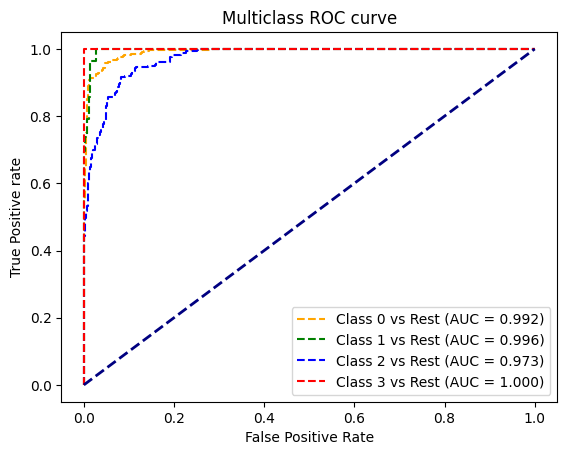

In [ ]:
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=f"Class 0 vs Rest (AUC = {auc_score[0]:.3f})")
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=f"Class 1 vs Rest (AUC = {auc_score[1]:.3f})")
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=f"Class 2 vs Rest (AUC = {auc_score[2]:.3f})")
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label=f"Class 3 vs Rest (AUC = {auc_score[3]:.3f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

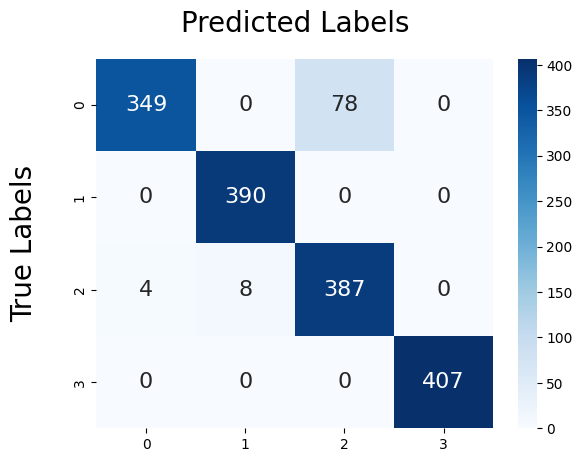

--------------------------------------------------------------------------------


In [ ]:
confusion(y_test, pred)

0- White Dwarf
1- Red Giant
2- Main Sequence
3- Protostar